In [1]:
import numpy as np
import pandas as pd
import janome
import matplotlib.pyplot as plt
import pickle
from janome.tokenizer import Tokenizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold

In [2]:
class WordDivider:
    def __init__(self):
        self.wakati = Tokenizer(wakati=True)
        self.t = Tokenizer()

    def wakati_words(self, text):
        if not text:
            return []

        words = []
        text = list(self.wakati.tokenize(text))
        for word in text:
            words.append(word)

        return words

    def surface_words(self, text):
        if not text:
            return []

        words = []
        for token in self.t.tokenize(text):
            words.append(token.base_form)
        return words

    def wakati_text(self, text):
        if not text:
            return []

        words = []
        wakati = list(self.wakati.tokenize(text))
        for word in wakati:
            words.append(word)

        output = ""
        for word in words:
            output += word
            output += " "
        return output


In [6]:
count = CountVectorizer()
df = pd.read_csv("./data4.csv", encoding="cp932")
a = df[df["comment_sentence"] == "デマを流すにしても悪質過ぎる。"]
b = df[df["comment_sentence"] == "いつまでステレオタイプのキモオタを妄想してるんですか……。"]
c = df[df["comment_sentence"] == "議員と言う役職の本来の仕事を知らないんだね"]
d = df[df["comment_sentence"] == "知らないことをギャンブル呼ばわりするとかバカすぎです。"]
e = df[df["comment_sentence"] == "もう言っている事が無茶苦茶、支離滅裂ですね。"]
# 欠測値の削除
df = df.dropna()
df = df.loc[:, "comment_sentence":"label"]
print(df["label"].unique())
df = df.replace({"label": {170: 6, 0: 6, 1: 6, 2: 6, 5: 6}})

# 訓練データを通常文とツイート行為の否定(3,4)に分ける
df = df.replace({"label": {3: 0, 4: 0, 6: 1}})
# クラスごとのデータ数を整える
# df_zero = df[df["label"] == 0]
# df_one = df[df["label"] == 1] 
# df_one_count = df_one["label"].value_counts()
# df_zero_shuffled = df_zero.sample(frac=1).reset_index(drop=True)
# df_zero = df_zero_shuffled.head(df_one_count[1])
# df = pd.concat([df_zero, df_one])
df_zero = df[df["label"] == 0]
df_one = df[df["label"] == 1] 
df_zero_count = df_zero["label"].value_counts()
df_one_shuffled = df_one.sample(frac=1).reset_index(drop=True)
df_one = df_one_shuffled.head(df_zero_count[0])
df_concat = pd.concat([df_zero, df_one])
# df_concat.to_csv("./experiment5.csv")
print(c)
print(d)
print(e)
a

[  6.   2.   4.   1.   0.   3. 170.   5.]
            id  opinion_id  comment_id  opinion_tweet_id  comment_tweet_id  \
33756  24505.0       252.0      1907.0      1.476830e+18      1.476840e+18   

       number                                       opinion_text  \
33756     1.0  NHK政治マガジン（12月28日）より\n武蔵野市・市議会議員（無所属）\n「外国籍の住民に...   

            comment_sentence  label  
33756  議員と言う役職の本来の仕事を知らないんだね    6.0  
           id  opinion_id  comment_id  opinion_tweet_id  comment_tweet_id  \
8842  30432.0       390.0      4872.0      1.477930e+18      1.477970e+18   

      number                                       opinion_text  \
8842     2.0  時代が変わり社会が変わったことで人生の攻略法も変わりました。\n\nこれまではいい大学いい会...   

                 comment_sentence  label  
8842  知らないことをギャンブル呼ばわりするとかバカすぎです。    6.0  
           id  opinion_id  comment_id  opinion_tweet_id  comment_tweet_id  \
8364  29950.0       377.0      4627.0      1.477410e+18      1.477480e+18   

      number                                       opinio

,id,opinion_id,comment_id,opinion_tweet_id,comment_tweet_id,number,opinion_text,comment_sentence,label
33695,22966.0,156.0,1134.0,1.475050e+18,1.475490e+18,1.0,ドイツや党「緑の党」が福島第１原発事故により数万人が死亡したと投稿して大炎上。どこの国でも原...,デマを流すにしても悪質過ぎる。,6.0


In [126]:
df = pd.read_csv("./experiment4.csv")
# 訓練データとテストデータの分割
train, test = train_test_split(df, test_size=0.30, stratify=df["label"].values)
# train.to_csv("./experiment6_train.csv")
# test.to_csv("./experiment6_test.csv")

In [3]:
train = pd.read_csv("./experiment4_train.csv")
test = pd.read_csv("./experiment4_test.csv")
print(train["label"].value_counts())
print(test["label"].value_counts())
x_train, y_train = train.loc[:, "comment_sentence"].tolist(), train.loc[:, "label"].tolist()
x_test, y_test = test.loc[:, "comment_sentence"].tolist(), test.loc[:, "label"].tolist()
wd = WordDivider()
x_train = [wd.wakati_text(text) for text in x_train]
x_test = [wd.wakati_text(text) for text in x_test]

0.0    295
1.0    295
Name: label, dtype: int64
0.0    127
1.0    127
Name: label, dtype: int64


Test Accuracy: 0.665
              precision    recall  f1-score   support

         0.0       0.66      0.68      0.67       127
         1.0       0.67      0.65      0.66       127

    accuracy                           0.67       254
   macro avg       0.67      0.67      0.67       254
weighted avg       0.67      0.67      0.67       254



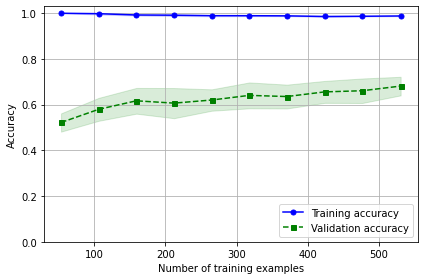

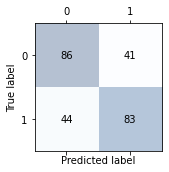

In [123]:
from sklearn.ensemble import StackingClassifier

#アンサンブルの作成(スタッキング）
estimators = [
    ('PA', PassiveAggressiveClassifier()),
    ('linear SVM', SGDClassifier(loss='hinge'))
]

clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

#パイプラインの作成
tfidf = TfidfVectorizer(ngram_range=(1, 5))
lr_tfidf = Pipeline([("vect", tfidf), ("clf", clf)])
lr_tfidf.fit(x_train, y_train)
# with open('model4.pickle', mode='wb') as f:
#       pickle.dump(lr_tfidf,f,protocol=2)
predict = lr_tfidf.predict(x_test)
print("Test Accuracy: %.3f" % lr_tfidf.score(x_test, y_test))
print(classification_report(y_test, predict))

#学習曲線の可視化
train_sizes, train_scores, test_scores = learning_curve(estimator=lr_tfidf,
                                                       X=x_train, y=y_train,
                                                       train_sizes=np.linspace(0.1, 1.0, 10),
                                                       cv=10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.0, 1.03])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

# 混同行列の作成
predict = lr_tfidf.predict(x_test)
confmat = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

Test Accuracy: 0.665
Test Recall: 0.677
Test Precision: 0.662
Test f1-score: 0.669
              precision    recall  f1-score   support

         0.0       0.66      0.68      0.67       127
         1.0       0.67      0.65      0.66       127

    accuracy                           0.67       254
   macro avg       0.67      0.67      0.67       254
weighted avg       0.67      0.67      0.67       254



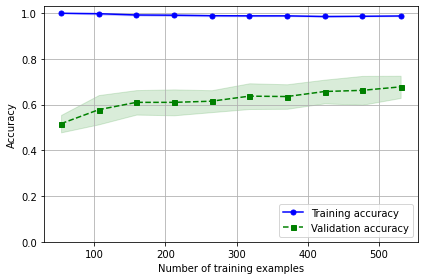

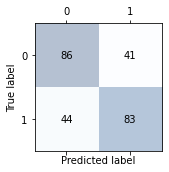

In [14]:
with open("model4.pickle", mode="rb") as f:
    lr_tfidf = pickle.load(f)
predict = lr_tfidf.predict(x_test)
print("Test Accuracy: %.3f" % accuracy_score(y_test, predict))
print("Test Recall: %.3f" % recall_score(y_test, predict, pos_label=0))
print("Test Precision: %.3f" % precision_score(y_test, predict, pos_label=0))
print("Test f1-score: %.3f" % f1_score(y_test, predict, pos_label=0))
print(classification_report(y_test, predict))

#学習曲線の可視化
train_sizes, train_scores, test_scores = learning_curve(estimator=lr_tfidf,
                                                       X=x_train, y=y_train,
                                                       train_sizes=np.linspace(0.1, 1.0, 10),
                                                       cv=10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.0, 1.03])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

# 混同行列の作成
predict = lr_tfidf.predict(x_test)
confmat = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

In [16]:
#誤分類データの抽出
false_predict_index = np.where(predict != y_test)
true_predict_index = np.where(predict == y_test)

false_x, false_y = [], []
for index in false_predict_index[0]:
    false_x.append(x_test[index])
    false_y.append(y_test[index])
false = pd.DataFrame(list(zip(false_x, false_y)), columns = ["comment", "label"])
false[false["label"] == 0]

true_x, true_y = [], []
for index in true_predict_index[0]:
    true_x.append(x_test[index])
    true_y.append(y_test[index])
true = pd.DataFrame(list(zip(true_x, true_y)), columns = ["comment", "label"])

true_0 = true[true["label"] == 0]
true_1 = true[true["label"] == 1]
false_0 = false[false["label"] == 0]
false_1 = false[false["label"] == 1]
# true_0.to_csv("./experiment5_true_0_predict.csv")
# true_1.to_csv("./experiment5_true_1_predict.csv")
# false_0.to_csv("./experiment5_false_0_predict.csv")
# false_1.to_csv("./experiment5_false_1_predict.csv")
false_1

,comment,label
1,新た な 刺激 や 出会い が 少なく なっ て き てる から 好き な こと や 気 に...,1.0
2,違反 者 は どう なる ん です か ？,1.0
3,容疑 者 の 人権 として 論じる ところ が 、 外国 人 の 人権 の 話 に なっ て...,1.0
4,大相撲 は 神事 の 一つ です ?,1.0
6,こないだ は 「 左翼 は 圧倒的 マイノリティ 」 と 言っ て た ネトウヨ さん も ...,1.0
8,愛子 天皇 は あり 得 ない 。,1.0
12,デマ を 流す に し て も 悪質 過ぎる 。,1.0
13,やっぱ バイオレントファット 太郎 の 名 は 伊達 で は ない の で は,1.0
15,どんな 主張 も 信じる の は 自由 だ けど 、 その 主張 を 基 に 他者 を 攻撃...,1.0
19,自己 満足 し て て 草,1.0


In [152]:
#パイプラインの可視化
from sklearn import set_config
set_config(display="diagram")
lr_tfidf

Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 5))),
                ('clf',
                 StackingClassifier(estimators=[('PA',
                                                 PassiveAggressiveClassifier()),
                                                ('linear SVM',
                                                 SGDClassifier())],
                                    final_estimator=LogisticRegression()))])

In [ ]:
import numpy as np
import pandas as pd
import janome
import matplotlib.pyplot as plt
from janome.tokenizer import Tokenizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

class WordDivider:
    def __init__(self):
        self.wakati = Tokenizer(wakati=True)
        self.t = Tokenizer()

    def wakati_words(self, text):
        if not text:
            return []

        words = []
        text = list(self.wakati.tokenize(text))
        for word in text:
            words.append(word)

        return words

    def surface_words(self, text):
        if not text:
            return []

        words = []
        for token in self.t.tokenize(text):
            words.append(token.base_form)
        return words

    def wakati_text(self, text):
        if not text:
            return []

        words = []
        wakati = list(self.wakati.tokenize(text))
        for word in wakati:
            words.append(word)

        output = ""
        for word in words:
            output += word
            output += " "
        return output

count = CountVectorizer()
df = pd.read_csv("./data.csv", encoding="cp932")

# 欠測値の削除
df = df.dropna()
df = df.loc[:, "comment_sentence":"label"]
# print(df["label"].unique())
df = df.replace({"label": {170: 6, 0: 6, 1: 6, 2: 6, 5: 6}})

# 訓練データを通常文とツイート行為の否定(3,4)に分ける
df = df.replace({"label": {6: 0, 3: 1, 4: 1}})
x = df.iloc[:, 0]
y = df.iloc[:, 1]
print(type(y[0]))
wd = WordDivider()
# 訓練データとテストデータの分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=df["label"].values)
print(y_train.value_counts())
count_train_class_zero = y_train.value_counts()[1]
print(count_train_class_zero)
under = RandomUnderSampler(sampling_strategy={0:count_train_class_zero*0.5, 1:count_train_class_zero}, random_state=100)
x_train, y_train = under.fit_resample(pd.DataFrame(x_train), pd.DataFrame(y_train))
print(test["label"].value_counts())
x_train, y_train = train.loc[:, "comment_sentence"].tolist(), train.loc[:, "label"].tolist()
x_test, y_test = test.loc[:, "comment_sentence"].tolist(), test.loc[:, "label"].tolist()
x_train = [wd.wakati_text(text) for text in x_train]
x_test = [wd.wakati_text(text) for text in x_test]